# Dynamic Matrix Control

## Question

Consider following process with transfer function $G_p(s)$:

$$
g_p(s)=\frac
{0.5848(-0.3549s+1)}
{0.1828s^2+0.8627s+1}
$$

plot response using DMC with parameters:

|$\Delta t$|N|P|M|
|---|---|---|---|
|0.1|50|25|1|
|0.1|50|10|1|
|0.1|50| 8|1|
|0.1|50| 7|1|

In [1]:
#import packages
import numpy as np;
import control;
import matplotlib.pyplot as plt;

## 1 Finite Step Response

In [2]:
num=0.5849*np.array([-0.3549,1.0])
den=[0.1828,0.8627,1.0]
Gp=control.tf(num,den)
print(Gp)


   -0.2076 s + 0.5849
-------------------------
0.1828 s^2 + 0.8627 s + 1



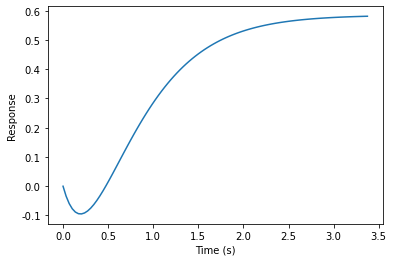

In [3]:
(T,yout)=control.step_response(Gp)
plt.plot(T,yout)
plt.xlabel("Time (s)")
plt.ylabel("Response")
plt.show()

## Dynamic Matrix Control

In [14]:
import simupy.systems
def MPC(t,u):
    return 0

constroller=simupy.systems.SystemFromCallable(MPC,1,1)
Gp_ss=control.tf2ss(Gp)
process=simupy.systems.LTISystem(Gp_ss.A,Gp_ss.B,Gp_ss.C)

In [4]:


def Control(Gp:control.TransferFunction,T:np.ndarray,controller):
    yout=np.zeros(T.size)
    u=np.zeros(T.size)
    (T,S)=control.step_response(Gp,T)
    for i in range(1,T.size):
        u1=controller(T[i],yout[0:i])
        if u1==None:
            u[i]=u[i-1]
        else:
            u[i]=u1
            for j in range(i,T.size):
                yout[j]=yout[j]+(u[i]-u[i-1])*S[j-i]
    return (T,yout,u)

In [9]:
Gp_ss=control.tf2ss(Gp)
control.tf2io

StateSpace(array([[-4.71936543, -5.47045952],
       [ 1.        ,  0.        ]]), array([[1.],
       [0.]]), array([[-1.13556351,  3.19967177]]), array([[0.]]))

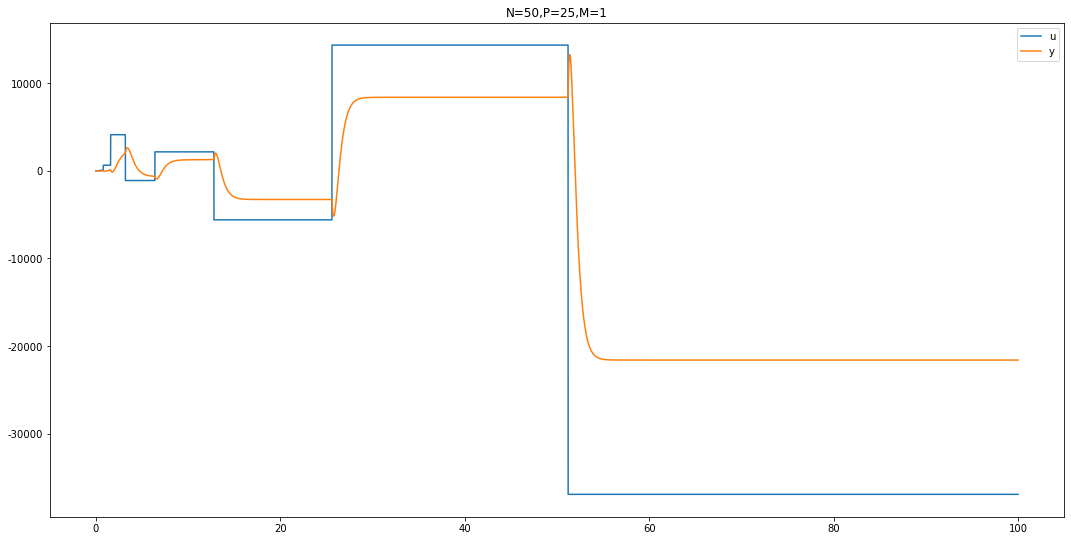

In [5]:
delta_t_list=[0.1,0.1,0.1,0.1]
N_list=[50,50,50,50]
P_list=[25,10,8,7]
M_list=[1,1,1,1]
plt.rcParams["figure.figsize"] = (40,20)
for i in range(0,1):
    delta_t=delta_t_list[i]
    N=N_list[i]
    P=P_list[i]
    M=M_list[i]
    ax=plt.subplot(2,2,i+1)

    T=np.arange(N+1)*delta_t,
    (T,S)=control.step_response(Gp,T)
    Wm=np.zeros((P,M))
    Q=np.diagflat(np.ones((1,P)))
    R=np.zeros((M,M))#np.diagflat(np.ones((1,M)))
    for i in range(P):
        for j in range(M):
            if i+j>=min(M,P):
                Wm[i,j]=S[i+j-min(M,P)+1]
    a=(np.dot(np.dot(Wm.T,Q),Wm)+R)
    Km=np.dot(np.linalg.inv(a),np.dot(Wm.T,Q))
    
    h=np.ones((N+1,1))*0.5
    y0=np.zeros((N+1,1)) # 模型预测
    def controller(t,y):
        global y0
        if t%delta_t == 0:
            Yr=np.ones((P,1))
            ycor=y0+h*(y[-1]-y0[0])
            y0=np.dot(S,ycor)
            E=Yr-y0
            Um=np.dot(Km,E)
            return Um[0]
        else:
            return None
    T=np.arange(0,100,0.01*delta_t)
    (T,yout,u)=Control(Gp,T,controller)
    
    plt.plot(T,u)
    plt.plot(T,yout)
    plt.legend(['u','y'])
    plt.title("N={},P={},M={}".format(N,P,M))

## References

- Siang Lim.February 2020.[Implementing Dynamic Matrix Control in Python](https://github.com/csianglim/DMC/blob/master/DMC.ipynb)
- Matlab.[Dynamic Matrix Control Tutorial](https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/19479/versions/1/previews/html/dmctutorial.html)